In [1]:
! pip install fastai==2.3.1 > /dev/null

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
! pip install pillow==8.2.0 

     |████████████████████████████████| 3.0 MB 5.0 MB/s eta 0:00:01
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.3.1
    Uninstalling Pillow-8.3.1:
      Successfully uninstalled Pillow-8.3.1
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [3]:
import fastai; print(fastai.__version__)

2.3.1


In [4]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from matplotlib import patches, patheffects
from fastai.vision.all import *
from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops

In [8]:
# lst_categories = []
# lst_categories.append({'id': 0, 'name' : 'none'})
# lst_categories.append({'id': 1, 'name' : 'typical'})
# lst_categories.append({'id': 2, 'name' : 'indeterminate'})
# lst_categories.append({'id': 3, 'name' : 'atypical'})
# lst_categories

[{'id': 0, 'name': 'none'},
 {'id': 1, 'name': 'typical'},
 {'id': 2, 'name': 'indeterminate'},
 {'id': 3, 'name': 'atypical'}]

In [5]:
# FULL_RUN = False

In [5]:
path = Path('../data-siim/train/')
path_im = path/'images'
path_lbl = path/'masks'
get_msk = lambda o: path/'masks'/f'{o.stem}{o.suffix}'

In [6]:
fnames = get_image_files(path_im)
lbl_names = get_image_files(path_lbl)

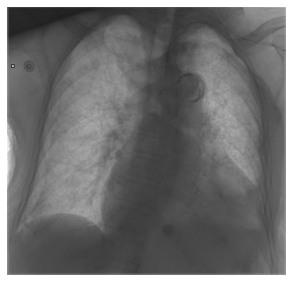

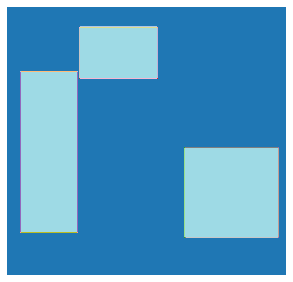

In [7]:
i = 17
img_fn = fnames[i]
img = PILImage.create(img_fn)
img.show(figsize=(5,5));
msk = PILMask.create(get_msk(img_fn))
msk.show(figsize=(5,5), alpha=1);

In [9]:
# codes = np.array(['none','typical', 'indeterminate', 'atypical' ], dtype = str); codes


array(['none', 'typical', 'indeterminate', 'atypical'], dtype='<U13')

In [10]:
# codes = [cat['name'] for cat in lst_categories]; codes

['none', 'typical', 'indeterminate', 'atypical']

In [8]:
codes = ['none', 'typical', 'indeterminate', 'atypical']

In [9]:
def get_subset_data(path):
    return fnames[0:100]

In [10]:
siimblock = DataBlock(blocks=(ImageBlock, MaskBlock(codes = codes)),
    get_items=get_image_files,
    splitter=RandomSplitter(),
    get_y= get_msk,
    item_tfms=Resize(768, method = "squish"),
    batch_tfms= [Normalize.from_stats(*imagenet_stats)]
    )

In [11]:
siimblock.summary(path/'images')

Setting-up type transforms pipelines
Found 5300 items
2 datasets of sizes 4240,1060
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../data-siim/train/images/36815bf5f063.png
    applying PILBase.create gives
      PILImage mode=RGB size=2989x2956
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../data-siim/train/images/36815bf5f063.png
    applying <lambda> gives
      ../data-siim/train/masks/36815bf5f063.png
    applying PILBase.create gives
      PILMask mode=L size=2989x2956

Final sample: (PILImage mode=RGB size=2989x2956, PILMask mode=L size=2989x2956)


Found 5300 items
2 datasets of sizes 4240,1060
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create
Setting up after_item: Pipeline: AddMaskCodes -> Resize -- {'size': (768, 768), 'method': 'squish', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting u

In [13]:
dls = siimblock.dataloaders(path/'images', bs=2)

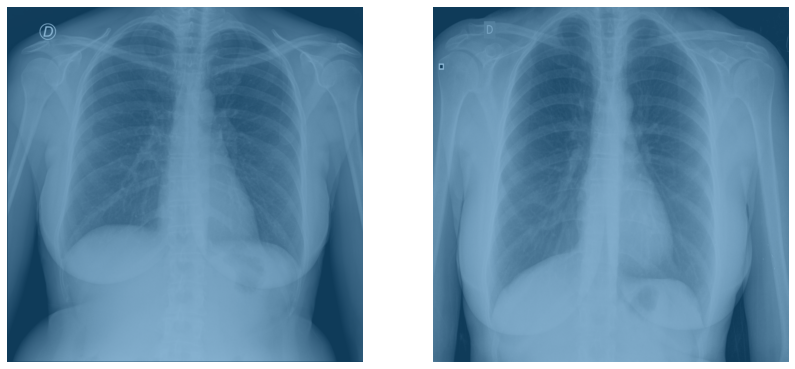

In [14]:
dls.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14,10))

In [15]:
dls.vocab = codes

In [16]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['none']; void_code

0

In [17]:
def acc_seg(inp, targ):
    if ((inp is None) or (targ is None)): return(0)
    targ = targ.squeeze(1)
    mask = targ != void_code
    ret = (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()
    if math.isnan(ret): ret = 0
    return (ret)

In [18]:
opt = ranger

In [19]:
learn = unet_learner(dls, resnet34, metrics=acc_seg, self_attention=True, act_cls=Mish, opt_func=opt, cbs=CSVLogger())

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [20]:
os.listdir("./models")

['siim-seg-011-resnet34-colab.pth',
 '.ipynb_checkpoints',
 'seg-model-pneumonia-detect-001.pth',
 'siim-seg-004-resnet34.pth',
 'siim-segmentation-resnet34-30072021-120258.pth',
 '_tmp.pth',
 'siim-segmentation-resnet34-30072021-092820.pth']

In [21]:
learn.model_dir = "./models"

In [22]:
learn = learn.load("siim-segmentation-resnet34-30072021-120258")

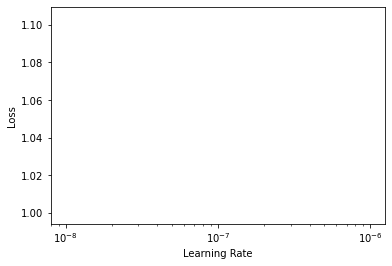

In [ ]:
learn.lr_find()

In [26]:
learn.recorder.lrs

[1e-07,
 1.202264434617413e-07,
 1.4454397707459274e-07,
 1.7378008287493754e-07,
 2.0892961308540395e-07,
 2.51188643150958e-07]

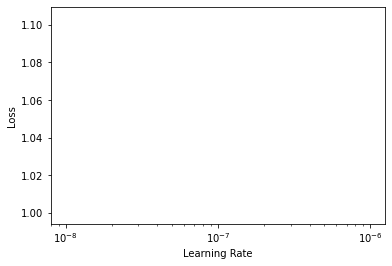

In [27]:
learn.recorder.plot_lr_find()